In [1]:
using LightGraphs
using GraphPlot
using Plots
using ProgressBars

In [2]:
gridsize=1450
bamodel=barabasi_albert(gridsize^2, 3, 2)
lattice=LightGraphs.grid((gridsize,gridsize),periodic=true)
net=bamodel
#gplot(net)

{2102500, 4205000} undirected simple Int64 graph

In [3]:
#'reasonable' parameters
pop=1450^2
p=0.2 #a guess - we'll tune this to get approx 300 infections are one month
q=1/7 #"up to" two weeks
r=1/7 #about two weeks for mild, 3-6 for severe
ndays=30
nseeds=20 #probably too many, consider dropping.

20

In [4]:
#initialise and seed
state=Array{Int8,2}(undef,1,pop) #this is a bit wasteful, there must be a better categorical way to do this...
state[1]=3
state[1:pop].=1;
state[rand((1:pop),(1,nseeds))].=2; #seeds should be exposed cases

In [5]:
#keep count of everything
st=Array{UInt64,1}(undef,ndays)
ex=Array{UInt64,1}(undef,ndays)
fe=Array{UInt64,1}(undef,ndays)
rm=Array{UInt64,1}(undef,ndays)
st[1]=count(x->x==1,state)
ex[1]=count(x->x==2,state)
fe[1]=count(x->x==3,state)
rm[1]=count(x->x==4,state);

In [6]:
#run once:
iter = ProgressBar(1:ndays)
for i in iter
    for v in vertices(net)
        if state[v]==1
            for n in all_neighbors(net, v)
                if state[n]==3 && rand(Float64).<p
                    state[v]=2   #susceptible becomes exposed
                end
            end
        elseif state[v]==2 && rand(Float64).<q
            state[v]=3 #exposed becomes infectious
        elseif state[v]==3 && rand(Float64).<r
            state[v]=4 #infectious becomes removed
        end
    end
    st[i]=count(x->x==1,state)
    ex[i]=count(x->x==2,state)
    fe[i]=count(x->x==3,state)
    rm[i]=count(x->x==4,state)
end

0.0%┣                                           ┫ 0/30 [00:00<00:-2, -20.0 it/s]

UndefVarError: UndefVarError: net not defined

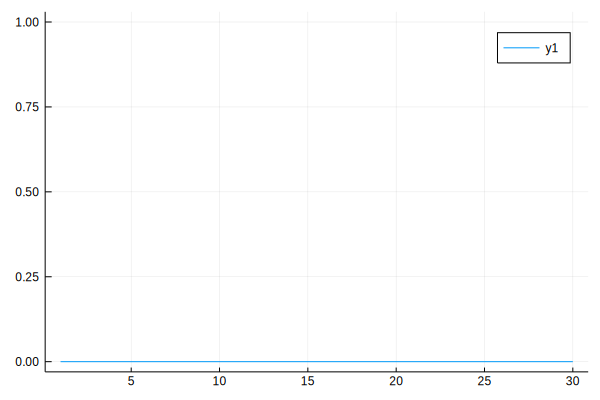

In [7]:
plot(1:ndays,fe)

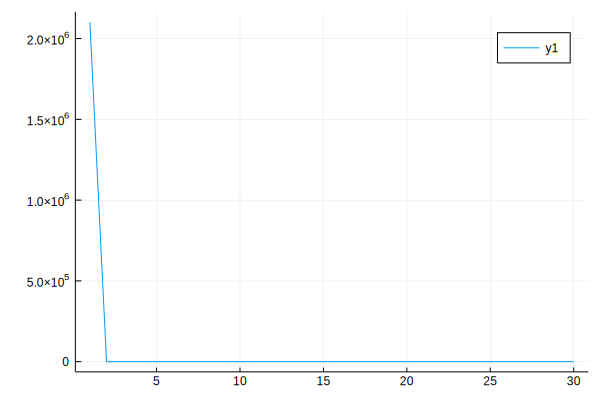

In [8]:
plot(st)

In [9]:
#got that working ... put it all together
function episim(net1,net2)
    
    pop=1450^2
    p=0.15 #a guess - we'll tune this to get approx 300 infections are one month
    q=1/10 #"up to" two weeks
    r=1/7 #about two weeks for mild, 3-6 for severe
    ndays=90
    nseeds=5 #probably too many, consider dropping.
    
    state=Array{Int8,2}(undef,1,pop) #this is a bit wasteful, there must be a better categorical way to do this...
    state[1:pop].=1;
    state[rand((1:pop),(1,nseeds))].=2; #seeds should be exposed cases
    
    st=Array{UInt64,1}(undef,ndays)
    ex=Array{UInt64,1}(undef,ndays)
    fe=Array{UInt64,1}(undef,ndays)
    rm=Array{UInt64,1}(undef,ndays)
    st[1]=count(x->x==1,state)
    ex[1]=count(x->x==2,state)
    fe[1]=count(x->x==3,state)
    rm[1]=count(x->x==4,state)
    
    net=net1
    iter = ProgressBar(1:ndays)
    for i in iter
        #switch network after 30 days
        if i==30
            net=net2
        end
        for v in vertices(net)
            if state[v]==1
                for n in all_neighbors(net, v)
                    if state[n]==3 && rand(Float64).<p
                        state[v]=2   #susceptible becomes exposed
                    end
                end
            elseif state[v]==2 && rand(Float64).<q
                state[v]=3 #exposed becomes infectious
            elseif state[v]==3 && rand(Float64).<r
                state[v]=4 #infectious becomes removed
            end
        end
        st[i]=count(x->x==1,state)
        ex[i]=count(x->x==2,state)
        fe[i]=count(x->x==3,state)
        rm[i]=count(x->x==4,state)
    end
    
    return st, ex, fe, rm

end

episim (generic function with 1 method)

In [10]:
gridsize=1450
bamodel=barabasi_albert(gridsize^2, 3, 2)
lattice=LightGraphs.grid((gridsize,gridsize),periodic=true)
St,Et,It,Rt=episim(bamodel,lattice) #switch between scale free and lattice (i.e. mixing to diffusion)

100.0%┣█████████████████████████████████████████┫ 90/90 [00:03<00:00, 27.9 it/s]


(UInt64[0x00000000002014df, 0x00000000002014dd, 0x00000000002014dd, 0x00000000002014dd, 0x00000000002014db, 0x00000000002014db, 0x00000000002014da, 0x00000000002014da, 0x00000000002014da, 0x00000000002014d8  …  0x000000000020121c, 0x000000000020120e, 0x00000000002011fe, 0x00000000002011eb, 0x00000000002011d8, 0x00000000002011c7, 0x00000000002011b9, 0x00000000002011a2, 0x0000000000201190, 0x0000000000201182], UInt64[0x0000000000000003, 0x0000000000000005, 0x0000000000000004, 0x0000000000000004, 0x0000000000000006, 0x0000000000000006, 0x0000000000000007, 0x0000000000000007, 0x0000000000000005, 0x0000000000000007  …  0x00000000000000a3, 0x000000000000009f, 0x000000000000009d, 0x00000000000000a5, 0x00000000000000a7, 0x00000000000000aa, 0x00000000000000a5, 0x00000000000000ad, 0x00000000000000a8, 0x00000000000000a2], UInt64[0x0000000000000002, 0x0000000000000002, 0x0000000000000003, 0x0000000000000003, 0x0000000000000003, 0x0000000000000003, 0x0000000000000002, 0x0000000000000002, 0x00000000

In [11]:
emptyg=erdos_renyi(gridsize^2,0)

{2102500, 0} undirected simple Int64 graph

In [12]:
St,Et,It,Rt=episim(bamodel,emptyg) #switch to lockdown

100.0%┣█████████████████████████████████████████┫ 90/90 [00:03<00:00, 33.4 it/s]


(UInt64[0x00000000002014df, 0x00000000002014df, 0x00000000002014df, 0x00000000002014df, 0x00000000002014de, 0x00000000002014de, 0x00000000002014dd, 0x00000000002014dc, 0x00000000002014db, 0x00000000002014da  …  0x00000000002012d7, 0x00000000002012d7, 0x00000000002012d7, 0x00000000002012d7, 0x00000000002012d7, 0x00000000002012d7, 0x00000000002012d7, 0x00000000002012d7, 0x00000000002012d7, 0x00000000002012d7], UInt64[0x0000000000000004, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x0000000000000003, 0x0000000000000004, 0x0000000000000005, 0x0000000000000005  …  0x0000000000000003, 0x0000000000000003, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002], UInt64[0x0000000000000001, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x0000000000000003, 0x0000000000000002, 0x0000000000000002, 0x0000000000000002, 0x00000000

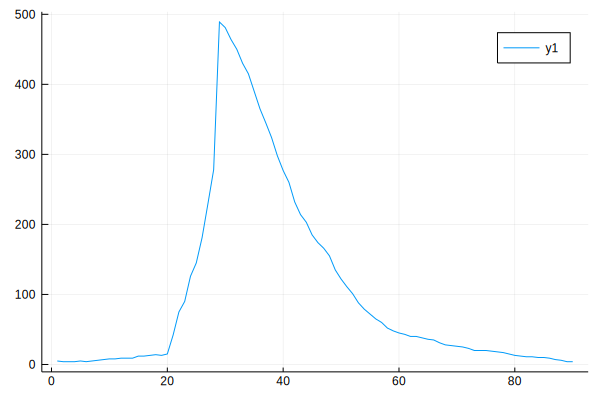

In [13]:
donothing=gridsize^2 .- St .- Rt
plot(donothing)


In [14]:
dogmend=dorogovtsev_mendes(gridsize^2)

{2102500, 4204997} undirected simple Int64 graph

In [15]:
wattstrog=watts_strogatz(gridsize^2, 4, 0.1) #last value is the rewiring parameter, we need to vary that
#9=0.1 means 10% of local contacts are rewired to random locations - i .e. violate complete lockdown 
#each node as 4 links so atleast one violation of local contact will occur in ~1-(1-p)^4

{2102500, 4205000} undirected simple Int64 graph

In [16]:
St,Et,It,Rt=episim(bamodel,wattstrog)

100.0%┣█████████████████████████████████████████┫ 90/90 [00:05<00:00, 17.1 it/s]


(UInt64[0x00000000002014de, 0x00000000002014de, 0x00000000002014de, 0x00000000002014de, 0x00000000002014de, 0x00000000002014de, 0x00000000002014de, 0x00000000002014dd, 0x00000000002014dc, 0x00000000002014dc  …  0x00000000002014b5, 0x00000000002014b4, 0x00000000002014b4, 0x00000000002014b4, 0x00000000002014b2, 0x00000000002014b2, 0x00000000002014b1, 0x00000000002014b1, 0x00000000002014b1, 0x00000000002014af], UInt64[0x0000000000000005, 0x0000000000000005, 0x0000000000000004, 0x0000000000000004, 0x0000000000000003, 0x0000000000000002, 0x0000000000000002, 0x0000000000000003, 0x0000000000000003, 0x0000000000000002  …  0x000000000000000a, 0x000000000000000b, 0x000000000000000b, 0x000000000000000a, 0x000000000000000b, 0x000000000000000a, 0x000000000000000b, 0x000000000000000b, 0x0000000000000008, 0x0000000000000008], UInt64[0x0000000000000001, 0x0000000000000000, 0x0000000000000001, 0x0000000000000001, 0x0000000000000002, 0x0000000000000003, 0x0000000000000003, 0x0000000000000003, 0x00000000

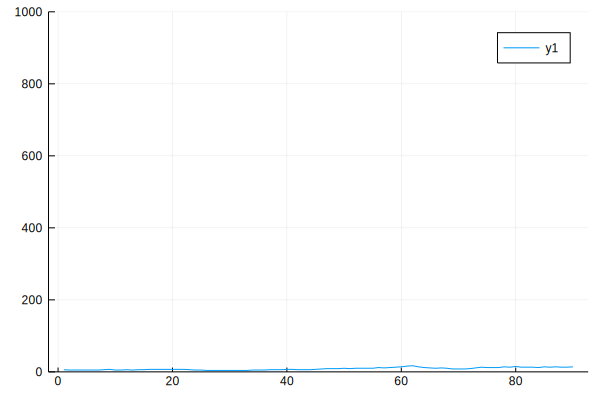

In [17]:
test=gridsize^2 .- St .- Rt
plot(test,ylims=(0,1000))


In [18]:
plot(1:90,[active99,active95,test,activeno,activeoff],title = "'Social' Distancing", xlabel="Day", ylabel="Active infected", label = ["95%" "85%" "70%" "none" "shutdown"], ylims=(1,2000), lw = 3)

UndefVarError: UndefVarError: active99 not defined

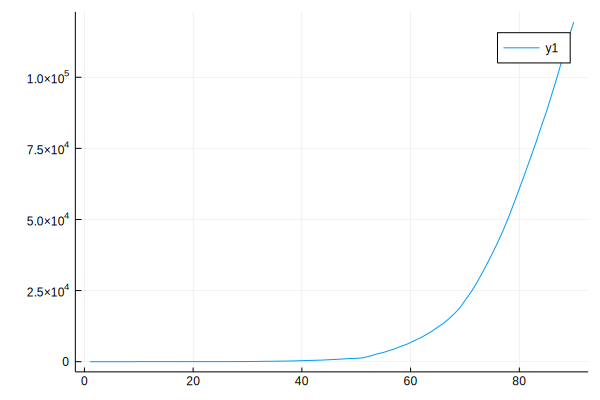

In [25]:
plot(gridsize^2 .- St .- Rt)

In [20]:
savefig("distancing")

In [21]:
p=0.01
1-(1-p)^4

0.039403990000000055

In [24]:
St,Et,It,Rt=episim(dogmend,dogmend)

100.0%┣█████████████████████████████████████████┫ 90/90 [00:08<00:00, 10.8 it/s]


(UInt64[0x00000000002014df, 0x00000000002014df, 0x00000000002014df, 0x00000000002014df, 0x00000000002014de, 0x00000000002014de, 0x00000000002014dc, 0x00000000002014db, 0x00000000002014da, 0x00000000002014d8  …  0x00000000001eb8b5, 0x00000000001e98ff, 0x00000000001e7875, 0x00000000001e54fc, 0x00000000001e31b8, 0x00000000001e0a91, 0x00000000001de1b5, 0x00000000001db62d, 0x00000000001d8a4c, 0x00000000001d5dc3], UInt64[0x0000000000000005, 0x0000000000000004, 0x0000000000000004, 0x0000000000000004, 0x0000000000000004, 0x0000000000000004, 0x0000000000000006, 0x0000000000000006, 0x0000000000000007, 0x0000000000000009  …  0x000000000000b5fb, 0x000000000000c33f, 0x000000000000d01b, 0x000000000000def9, 0x000000000000ebeb, 0x000000000000fba7, 0x0000000000010b27, 0x0000000000011c07, 0x0000000000012b9c, 0x0000000000013a99], UInt64[0x0000000000000000, 0x0000000000000001, 0x0000000000000001, 0x0000000000000001, 0x0000000000000002, 0x0000000000000001, 0x0000000000000001, 0x0000000000000002, 0x00000000